In [90]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Lasso
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

'''Import script which contains functions'''
import analysis_functions
from analysis_functions import get_r2
from analysis_functions import get_lassoCV
from analysis_functions import perform_randomizedLasso

from IPython.display import display, HTML

#If we want to time the implementation: 
#import time
#start_time = time.time()

Import the dataframes: 

In [91]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/Nov2017_Filtering/1seq_in_3samples/nochloro_absolute_otu_1seqin3samps.tsv', sep=' ', index_col=None, header=0, float_precision='high')
data_rel = pd.read_csv('data/Chloroplasts_removed/Nov2017_Filtering/1seq_in_3samples/nochloro_relative_1seqin3samps.tsv', sep=' ', index_col=None, header=0, float_precision='high')
target = pd.read_csv('data/Chloroplasts_removed/Nov2017_Filtering/1seq_in_3samples/nochloro_HNA_LNA_1seqin3samps.tsv', sep= ' ', index_col=0, header=0)

**2)**: At 01-05-'17 @marschmi found that a few samples can be seen as outliers, as they represent the bottom waters of productive inland lakes, resulting in a big difference of the HNA percentage. These samples are the following: Z14055F, Z14003F, Z14007F, Z14023F, Z14011F. A code of line is added, in order to be able to run the pipeline without these samples; 

In [92]:
#samples_to_drop = ['Z14055F', 'Z14003F', 'Z14007F', 'Z14023F', 'Z14011F']
#index = target.index.drop(samples_to_drop)

In [93]:
'''Set sample names as index and shuffle data'''
index = data_rel.index

#Remove outlier samples:
data_abs = data_abs.loc[index,:] 
data_rel = data_rel.loc[index,:]
target = target.loc[index,:]
#productivity = productivity.loc[index,:]

#Shuffle data: 
data_abs = data_abs.sample(frac=1, random_state=3)
data_rel = data_rel.sample(frac=1, random_state=3)
target = target.sample(frac=1, random_state=3)
#productivity = productivity.sample(frac=1, random_state=3) 

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna.index)

#Create target columns of LNA-values: 
lna = target.loc[:,'LNA.cells']
lna_rel = lna/target.loc[:,'Total.cells']
lna = pd.Series(lna, index=lna.index)
lna_rel = pd.Series(lna_rel, index=lna.index)

In [94]:
#Some variables to store information and to create inner and outer CV-folds

data_rel = data_rel.loc[:, (data_rel != 0).any(axis=0)]
otus = list(data_rel.columns)

#cv_out = 10
cv = 5
#outer_cv = KFold(n_splits=cv_out, shuffle=False)

#otu_scores_cv = pd.DataFrame(columns=otus)
#r2_cv = np.zeros(cv_out)
#thresholds_cv = np.zeros(cv_out)

#pred = pd.Series(index=data_abs.index)
#final_scores = pd.DataFrame(columns=otus)

#thresholds = np.arange(0,1,0.01)
#t = 0

In [95]:
''' Standardize data '''
from analysis_functions import standardize_df
data_stand, scaler = standardize_df(data_rel,otus)

To do so, we use the **_Randomized Lasso_**: this method makes use of two kinds of randomization in order to select variables (i.e., OTU's) with a certain _stability_: (1) it fits a Lasso to various bootstrap subsamples and (2) it perturbs the initial weighting of certain variables. 

This results in a $score \in [0,1]$ that is assigned to variables, with 0 denoting the case where a variable is never chosen by the Lasso, and 1 denoting the case where a variable always is chosen. In other words, the higher the score, the more important a variable can be considered to be. 

**First goal: ** try to pinpoint those OTU's for which we are sure they are present in the '_HNA-cloud_'. 

**Univariate Feature Selection**: 

Let's compare two methods: 
- f_regression (f-score pearson correlation), 
- Mutual information,  
- (other methods can follow as well). 

In [96]:
f_regr, f_regr_p = f_regression(data_stand.loc[:,otus],hna)
r_spearman = np.zeros(len(otus))
p_spearman = np.zeros(len(otus))
for i in np.arange(0,len(otus)):
    r_spearman[i], p_spearman[i] = spearmanr(data_stand.loc[:,otus[i]],hna, axis=0)
uni_fs = pd.DataFrame(f_regr, index=otus, columns = ['f_regr'])
uni_fs['p-value'] = f_regr_p
uni_fs['r_spearman'] = r_spearman
uni_fs['p_spearman'] = p_spearman
#uni_fs['mi'] = mutual_info_regression(data_stand.loc[:,otus],hna)
#uni_fs.sort_values(ascending=False,inplace=True, by='f_regr')
display(uni_fs.head(10))

,f_regr,p-value,r_spearman,p_spearman
Otu000001,92.593481,1.075090e-17,-0.617883,4.583005e-19
Otu000004,0.001832,9.659131e-01,-0.095045,2.203878e-01
Otu000005,14.080977,2.417433e-04,0.254057,8.903382e-04
Otu000006,1.398321,2.386959e-01,-0.244539,1.400420e-03
Otu000007,3.931881,4.902860e-02,-0.104781,1.764693e-01
Otu000009,0.689251,4.076117e-01,0.105774,1.723854e-01
Otu000010,4.177178,4.255217e-02,0.200215,9.265306e-03
Otu000011,4.760812,3.052041e-02,0.071703,3.556825e-01
Otu000012,0.704349,4.025334e-01,0.006086,9.375965e-01
Otu000014,1.897565,1.702055e-01,0.144623,6.143066e-02


In [97]:
uni_fs.to_csv('F_test_spearman_hna_1seq3.csv')

Select otu's based on $p < \text{thr}$: 

In [98]:
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p-value'].values < 0.05]
print('Number of selected OTUs using F-test with p < 0.05: ' + str(len(uni_fs_selected_f)))
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p-value'].values < 0.01]
print('Number of selected OTUs using F-test with p < 0.01: ' + str(len(uni_fs_selected_f)))
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p_spearman'].values < 0.05]
print('Number of selected OTUs using spearman correlation with p < 0.05: ' + str(len(uni_fs_selected_f)))
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p_spearman'].values < 0.01]
print('Number of selected OTUs using spearman correlation with p < 0.01: ' + str(len(uni_fs_selected_f)))

Number of selected OTUs using F-test with p < 0.05: 690
Number of selected OTUs using F-test with p < 0.01: 361
Number of selected OTUs using spearman correlation with p < 0.05: 900
Number of selected OTUs using spearman correlation with p < 0.01: 520


What happens when we tune a threshold in function of the f_score: 

In [99]:
#from analysis_functions import get_r2_scores
#thr_otu_f_regr_hna, r2_otu_f_regr_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, uni_fs['f_regr'], cv)
#thr_otu_f_regr_lna, r2_otu_f_regr_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, uni_fs['f_regr'], cv)

In [100]:
#plt.figure()
#sns.regplot(x=thr_otu_f_regr_hna,y=r2_otu_f_regr_hna, fit_reg=False, label='HNA')
#sns.regplot(x=thr_otu_f_regr_lna,y=r2_otu_f_regr_lna, fit_reg=False, label='LNA')
#plt.xlabel('F-score', size=22)
#plt.xticks(size=10)
#plt.ylabel(r'$R^2$', size=22)
#plt.yticks(size=10)
#plt.title('F-test', size=24)
#plt.legend()
#plt.show()

In [101]:
thr_otu_sp_hna, r2_otu_sp_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, np.absolute(uni_fs['r_spearman']), cv)
thr_otu_sp_lna, r2_otu_sp_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, np.absolute(uni_fs['r_spearman']), cv)

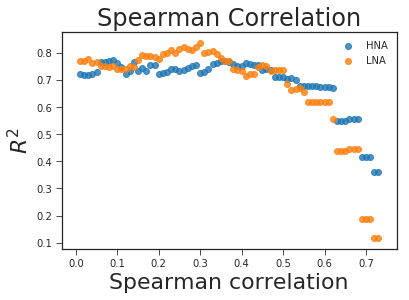

In [102]:
plt.figure()
sns.regplot(x=thr_otu_sp_hna,y=r2_otu_sp_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_sp_lna,y=r2_otu_sp_lna, fit_reg=False, label='LNA')
plt.xlabel('Spearman correlation', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.title('Spearman Correlation', size=24)
plt.legend()
plt.show()

In [103]:
#uni_fs.sort_values(ascending=False,inplace=True, by='mi')
#display(uni_fs.head(10))
#thr_otu_mi_hna, r2_otu_mi_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, uni_fs['mi'], cv)
#thr_otu_mi_lna, r2_otu_mi_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, uni_fs['mi'], cv)

In [104]:
#plt.figure()
#sns.regplot(x=thr_otu_mi_hna,y=r2_otu_mi_hna, fit_reg=False, label='HNA')
#sns.regplot(x=thr_otu_mi_lna,y=r2_otu_mi_lna, fit_reg=False, label='LNA')
#plt.xlabel('MI', size=22)
#plt.xticks(size=10)
#plt.ylabel(r'$R^2$', size=22)
#plt.yticks(size=10)
#plt.title('Mutual Information', size=24)
#plt.legend()
#plt.show()

In [105]:
from analysis_functions import get_lassoCV_alpha

alpha = get_lassoCV_alpha(data_stand.loc[:,otus],hna,otus,cv)
    
otu_scores = pd.DataFrame(perform_randomizedLasso(data_stand.loc[:,otus], hna, alpha), index=otus, columns=['score'])
otu_scores.sort_values(ascending=False,inplace=True, by='score')

thr_otu_scores_hna, r2_otu_scores_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, otu_scores, cv)
thr_otu_scores_lna, r2_otu_scores_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, otu_scores, cv)

/home/prubbens/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


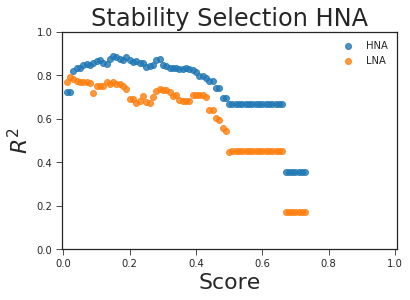

In [106]:
plt.figure()
sns.regplot(x=thr_otu_scores_hna,y=r2_otu_scores_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_scores_lna,y=r2_otu_scores_lna, fit_reg=False, label='LNA')
plt.axis([-0.005,1.005,0,1])
plt.xlabel('Score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.legend()
plt.title('Stability Selection HNA', size=24)
plt.show()

In [107]:
r2_final = r2_otu_scores_hna.max()
thr = thr_otu_scores_hna[r2_otu_scores_hna.argmax()]
print('R²_cv(hna): ' + str(r2_final) )
print('Threshold score: ' + str(thr))

R²_cv(hna): 0.889083950252
Threshold score: 0.15


In [108]:
otu_scores = otu_scores.assign(abun_abs_mean = data_abs.loc[:,otus].mean())
otu_scores = otu_scores.assign(abun_abs_CV = data_abs.loc[:,otus].std()/data_abs.loc[:,otus].mean())
otu_scores =  otu_scores.assign(abun_rel_mean = data_rel.loc[:,otus].mean())
otu_scores = otu_scores.assign(abun_rel_CV = data_rel.loc[:,otus].std()/data_rel.loc[:,otus].mean())
otu_scores['r_spearman'] = uni_fs.loc[otu_scores.index,'r_spearman']
otu_scores['p_spearman'] = uni_fs.loc[otu_scores.index,'p_spearman']
otu_scores.to_csv('Final/hnascores_otus_1seq3_rel.csv')

In [109]:
otu_scores_selected = otu_scores[otu_scores.score.values>thr]
selected_otus = otu_scores_selected.index
otu_scores_selected.to_csv('Final/hnascores_otus_tuned_thr_'+str(thr)+'_1seq3_rel.csv')
display(otu_scores_selected.head(10))
print('Size list selected OTUs: ' + str(len(selected_otus)))

,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV,r_spearman,p_spearman
Otu000001,0.723333,371601.089939,0.720490,0.095239,0.631085,-0.617883,4.583005e-19
Otu000173,0.656667,8892.157986,1.953307,0.001270,1.729254,0.720378,3.576806e-28
Otu000060,0.653333,26355.897534,1.500728,0.003828,1.085250,0.674605,1.185648e-23
Otu000335,0.500000,6250.999417,2.165661,0.000927,1.748611,0.526300,2.357276e-13
Otu000074,0.486667,12612.177451,0.802366,0.003443,0.878576,-0.341746,5.795455e-06
Otu000025,0.480000,78679.771581,1.040659,0.015052,0.771797,0.402280,6.468405e-08
Otu000160,0.466667,18969.044325,3.110295,0.002236,2.822739,0.469945,1.303572e-10
Otu000075,0.460000,18236.076497,1.294892,0.006315,1.554322,-0.408794,3.770124e-08
Otu000088,0.456667,5087.595794,1.342708,0.001828,1.561502,-0.426282,8.348258e-09
Otu000981,0.453333,631.164361,4.614274,0.000101,4.698286,0.188852,1.422102e-02


Size list selected OTUs: 185


In [110]:
print('R²_cv of HNA-selected OTUs in function of LNA: ' + str(r2_otu_scores_lna[r2_otu_scores_hna.argmax()]) )

R²_cv of HNA-selected OTUs in function of LNA: 0.76884222949


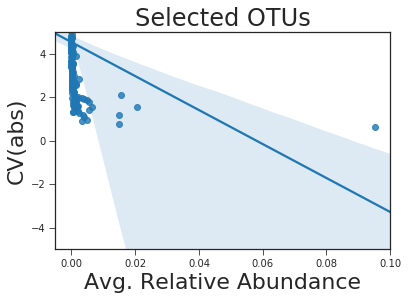

In [111]:
plt.figure()
sns.regplot(x='abun_rel_mean',y='abun_rel_CV', data=otu_scores_selected)
plt.axis([-0.005,0.1,-5,5])
plt.xlabel('Avg. Relative Abundance', size=22)
plt.xticks(size=10)
plt.ylabel('CV(abs)', size=22)
plt.yticks(size=10)
plt.title('Selected OTUs', size=24)
plt.show()

In [112]:
#optimal_scores.to_csv('HNA_selectedOTUs_stand_abun_remov' + str(abun)+'_R2'+str(r2_final)+'.csv')

**Second goal**: Can we use the same pipeline to predict the _LNA_-counts? 

In [113]:
f_regr_lna, f_regr_p_lna = f_regression(data_stand.loc[:,otus],lna)
uni_fs_lna = pd.DataFrame(f_regr_lna, index=otus, columns = ['f_regr'])
uni_fs_lna['p-value'] = f_regr_p_lna
r_spearman = np.zeros(len(otus))
p_spearman = np.zeros(len(otus))
for i in np.arange(0,len(otus)):
    r_spearman[i], p_spearman[i] = spearmanr(data_stand.loc[:,otus[i]],lna, axis=0)
uni_fs_lna = pd.DataFrame(f_regr_lna, index=otus, columns = ['f_regr'])
uni_fs_lna['p-value'] = f_regr_p
uni_fs_lna['r_spearman'] = r_spearman
uni_fs_lna['p_spearman'] = p_spearman
#uni_fs_lna['mi'] = mutual_info_regression(data_stand.loc[:,otus],lna)
#uni_fs_lna.sort_values(ascending=False,inplace=True, by='f_regr')
display(uni_fs_lna.head(10))

,f_regr,p-value,r_spearman,p_spearman
Otu000001,36.177467,1.075090e-17,-0.399343,8.220409e-08
Otu000004,0.186475,9.659131e-01,-0.058127,4.542033e-01
Otu000005,33.109097,2.417433e-04,0.499578,5.438806e-12
Otu000006,3.074349,2.386959e-01,-0.177144,2.161303e-02
Otu000007,2.787702,4.902860e-02,-0.072403,3.509942e-01
Otu000009,0.198051,4.076117e-01,0.010409,8.934764e-01
Otu000010,19.063154,4.255217e-02,0.369036,8.548234e-07
Otu000011,0.327921,3.052041e-02,0.009217,9.056153e-01
Otu000012,0.302166,4.025334e-01,0.101791,1.892079e-01
Otu000014,4.678019,1.702055e-01,0.188813,1.424149e-02


In [114]:
uni_fs_selected_f_lna = uni_fs_lna[uni_fs_lna.loc[:,'p-value'].values < 0.05]
print('Number of selected OTUs with p < 0.05: ' + str(len(uni_fs_selected_f_lna)))
uni_fs_selected_f_lna = uni_fs_lna[uni_fs_lna.loc[:,'p-value'].values < 0.01]
print('Number of selected OTUs with p < 0.01: ' + str(len(uni_fs_selected_f_lna)))
uni_fs_selected_f = uni_fs_lna[uni_fs_lna.loc[:,'p_spearman'].values < 0.05]
print('Number of selected OTUs using spearman correlation with p < 0.05: ' + str(len(uni_fs_selected_f)))
uni_fs_selected_f = uni_fs_lna[uni_fs_lna.loc[:,'p_spearman'].values < 0.01]
print('Number of selected OTUs using spearman correlation with p < 0.01: ' + str(len(uni_fs_selected_f)))

Number of selected OTUs with p < 0.05: 690
Number of selected OTUs with p < 0.01: 361
Number of selected OTUs using spearman correlation with p < 0.05: 861
Number of selected OTUs using spearman correlation with p < 0.01: 575


In [115]:
uni_fs.to_csv('F_test_spearman_lna_1seq3.csv')

In [ ]:
#thr_otu_f_regr_lna, r2_otu_f_regr_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, uni_fs_lna['f_regr'], cv)
#thr_otu_f_regr_hna, r2_otu_f_regr_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, uni_fs_lna['f_regr'], cv)

In [ ]:
#plt.figure()
#sns.regplot(x=thr_otu_f_regr_hna,y=r2_otu_f_regr_hna, fit_reg=False, label='HNA')
#sns.regplot(x=thr_otu_f_regr_lna,y=r2_otu_f_regr_lna, fit_reg=False, label='LNA')
#plt.axis([-0.005,1.005,0,1])
#plt.xlabel('F-score', size=22)
#plt.xticks(size=10)
#plt.ylabel(r'$R^2$', size=22)
#plt.yticks(size=10)
#plt.title('F-test', size=24)
#plt.legend()
#plt.show()

In [119]:
thr_otu_sp_lna, r2_otu_sp_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, np.absolute(uni_fs_lna['r_spearman']), cv)
thr_otu_sp_hna, r2_otu_sp_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, np.absolute(uni_fs_lna['r_spearman']), cv)

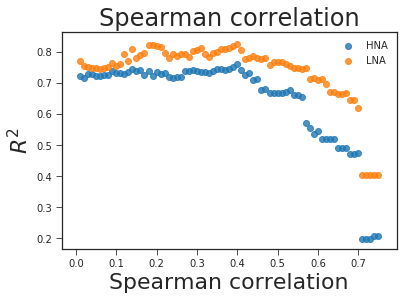

In [120]:
plt.figure()
sns.regplot(x=thr_otu_sp_hna,y=r2_otu_sp_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_sp_lna,y=r2_otu_sp_lna, fit_reg=False, label='LNA')
plt.xlabel('Spearman correlation', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.title('Spearman correlation', size=24)
plt.legend()
plt.show()

In [121]:
alpha = get_lassoCV_alpha(data_stand.loc[:,otus],lna,otus,cv)
otu_scores_lna = pd.DataFrame(perform_randomizedLasso(data_stand.loc[:,otus], lna, alpha), index=otus, columns=['score'])
otu_scores_lna.sort_values(ascending=False, inplace=True, by='score')

thr_otu_scores_lna, r2_otu_scores_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, otu_scores_lna, cv)
thr_otu_scores_hna, r2_otu_scores_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, otu_scores_lna, cv)

/home/prubbens/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


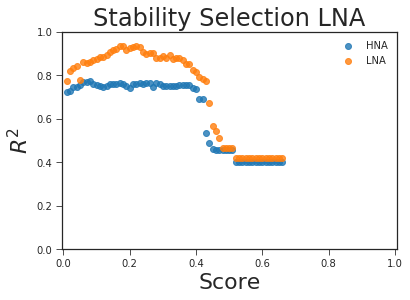

In [122]:
plt.figure()
sns.regplot(x=thr_otu_scores_hna,y=r2_otu_scores_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_scores_lna,y=r2_otu_scores_lna, fit_reg=False, label='LNA')
plt.axis([-0.005,1.005,0,1])
plt.xlabel('Score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.legend()
plt.title('Stability Selection LNA', size=24)
plt.show()

In [123]:
r2_final = r2_otu_scores_lna.max()
thr_lna = thr_otu_scores_lna[r2_otu_scores_lna.argmax()]
print('R²_cv(lna): ' + str(r2_final) )
print('Threshold score: ' + str(thr_lna))

R²_cv(lna): 0.935301695488
Threshold score: 0.17


In [124]:
otu_scores_lna = otu_scores_lna.assign(abun_abs_mean = data_abs.loc[:,otus].mean())
otu_scores_lna = otu_scores_lna.assign(abun_abs_CV = data_abs.loc[:,otus].std()/data_abs.loc[:,otus].mean())
otu_scores_lna =  otu_scores_lna.assign(abun_rel_mean = data_rel.loc[:,otus].mean())
otu_scores_lna = otu_scores_lna.assign(abun_rel_CV = data_rel.loc[:,otus].std()/data_rel.loc[:,otus].mean())
otu_scores_lna['r_spearman'] = uni_fs_lna.loc[otu_scores.index,'r_spearman']
otu_scores_lna['p_spearman'] = uni_fs_lna.loc[otu_scores.index,'p_spearman']
otu_scores_lna.to_csv('Final/lnascores_otus_abun_1seq3_rel.csv')


In [125]:
otu_scores_selected_lna = otu_scores_lna[otu_scores_lna.score.values>thr_lna]
selected_otus_lna = otu_scores_selected_lna.index
print('Size list selected OTUs: ' + str(len(selected_otus_lna)))
otu_scores_selected_lna.to_csv('Final/lnascores_otus_tuned_thr_'+str(thr_lna)+'_1seq3_rel.csv')
display(otu_scores_selected_lna.head(10))

Size list selected OTUs: 170


,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV,r_spearman,p_spearman
Otu000060,0.653333,26355.897534,1.500728,0.003828,1.085250,0.694417,1.664682e-25
Otu000075,0.503333,18236.076497,1.294892,0.006315,1.554322,-0.416956,1.885379e-08
Otu000053,0.470000,27862.529944,1.460392,0.004684,0.981394,0.371869,6.936269e-07
Otu000017,0.456667,46181.687512,1.174592,0.015009,1.172510,-0.591523,3.104283e-17
Otu001152,0.443333,107.638432,3.828249,0.000057,3.755027,-0.336061,8.446065e-06
Otu000113,0.433333,5888.695140,2.532970,0.000743,2.430206,0.617753,4.683937e-19
Otu000074,0.430000,12612.177451,0.802366,0.003443,0.878576,-0.478868,5.170210e-11
Otu000108,0.426667,16074.992429,2.334943,0.002090,2.019788,0.688021,6.848318e-25
Otu000597,0.426667,2065.701352,2.297885,0.000313,2.057057,0.467824,1.617707e-10
Otu000137,0.423333,3084.664828,1.846876,0.001490,2.591083,-0.420417,1.397457e-08


In [126]:
print('R²_cv of LNA-selected OTUs in function of HNA: ' + str(r2_otu_scores_hna[r2_otu_scores_lna.argmax()]) )

R²_cv of LNA-selected OTUs in function of HNA: 0.766692212031


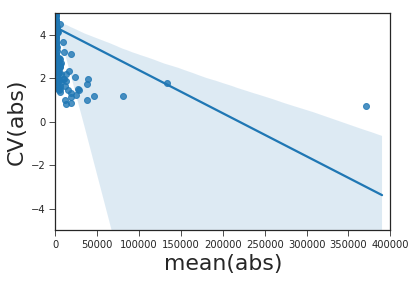

In [127]:
plt.figure()
sns.regplot(x='abun_abs_mean',y='abun_abs_CV', data=otu_scores_selected_lna)
plt.axis([0,400000,-5,5])
plt.xlabel('mean(abs)', size=22)
plt.xticks(size=10)
plt.ylabel('CV(abs)', size=22)
plt.yticks(size=10)
plt.show()

Let's compare the HNA- and LNA-lists, which OTU's are shared (_common_) and which are only part of the HNA- or LNA subset?: 

In [128]:
idx_hna = otu_scores_selected.index.difference(otu_scores_selected_lna.index)
idx_lna = otu_scores_selected_lna.index.difference(otu_scores_selected.index)
idx_common = otu_scores_selected.drop(idx_hna).index
pd.Series(idx_common).to_csv('commonOTU_HNALNA_abun.001_rel.csv')
print('Size subset OTUs only related to HNA: ' + str(len(idx_hna)) + '; opposed to total size: ' + str(len(otu_scores_selected)))
print('Size subset OTUs only related to LNA: ' + str(len(idx_lna)) + '; opposed to total size: ' + str(len(otu_scores_selected_lna)))
print('Size subset OTUs related to both: ' + str(len(idx_common)))

display(otu_scores_selected_lna.loc[idx_common,:].head(10))
#data_abs_raw = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
#data_abs_raw = data_abs_raw.loc[index,:]
#display(data_abs_raw.loc[:,idx_hna].sum(axis=1).values/hna.values)

Size subset OTUs only related to HNA: 108; opposed to total size: 185
Size subset OTUs only related to LNA: 93; opposed to total size: 170
Size subset OTUs related to both: 77


,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV,r_spearman,p_spearman
Otu000001,0.416667,371601.089939,0.720490,0.095239,0.631085,-0.399343,8.220409e-08
Otu000173,0.420000,8892.157986,1.953307,0.001270,1.729254,0.550682,1.047010e-14
Otu000060,0.653333,26355.897534,1.500728,0.003828,1.085250,0.694417,1.664682e-25
Otu000335,0.400000,6250.999417,2.165661,0.000927,1.748611,0.409629,3.514889e-08
Otu000074,0.430000,12612.177451,0.802366,0.003443,0.878576,-0.478868,5.170210e-11
Otu000160,0.393333,18969.044325,3.110295,0.002236,2.822739,0.565805,1.331391e-15
Otu000075,0.503333,18236.076497,1.294892,0.006315,1.554322,-0.416956,1.885379e-08
Otu000088,0.333333,5087.595794,1.342708,0.001828,1.561502,-0.467170,1.728538e-10
Otu000981,0.283333,631.164361,4.614274,0.000101,4.698286,0.175276,2.305683e-02
Otu000313,0.373333,2492.843861,2.222905,0.000331,1.941756,0.554891,5.959465e-15


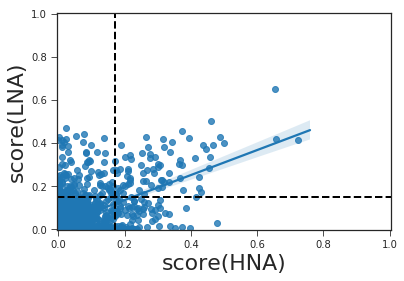

In [129]:
plt.figure()
sns.regplot(x=otu_scores.loc[:,'score'],y=otu_scores_lna.loc[otu_scores.index,'score'])
plt.axis([-0.005,1.005,-0.005,1.005])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('score(LNA)', size=22)
plt.yticks(size=10)
plt.axhline(y=thr, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr_lna, linewidth=2, linestyle='--', color = 'k')
plt.show()

This figure shows 4 area's: 
- (left top corner): OTU's selected solely in function of **LNA**-dynamics, 
- (right top corner): OTU's selected in function of both **HNA**- and **LNA**-dynamics, 
- (left bottom corner): OTU's that are _not_ selected, 
- (right bottom corner): OTU's selected solely in function of **HNA**-dynamics. 

Univariate vs. Stability selection

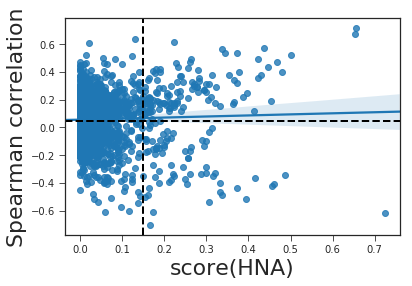

In [130]:
plt.figure()
sns.regplot(x=otu_scores.loc[:,'score'],y=uni_fs.loc[otu_scores.index,'r_spearman'])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Spearman correlation', size=22)
plt.yticks(size=10)
#plt.yscale('log')
plt.axhline(y=0.05, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr, linewidth=2, linestyle='--', color = 'k')
#plt.axis([-0.005,1.005,0.0000000000000000000001, 1])
plt.show()

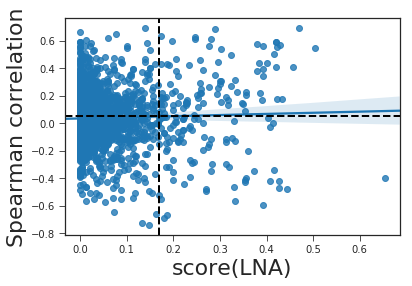

In [131]:
plt.figure()
sns.regplot(x=otu_scores_lna.loc[:,'score'],y=uni_fs_lna.loc[otu_scores.index,'r_spearman'])
plt.xlabel('score(LNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Spearman correlation', size=22)
plt.yticks(size=10)
#plt.yscale('log')
plt.axhline(y=0.05, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr_lna, linewidth=2, linestyle='--', color = 'k')
#plt.axis([-0.005,1.005,0.0000000000000000000001, 1])
plt.show()

This analysis shows that the HNA/LNA dynamics cannot solely be attributed to OTU's that are present in the respective cloud; this is also clear from the mutual correlation between HNA- and LNA-counts ( $\rho(\text{HNA,LNA}) = 0.75$ ). 

I see two reasons for this: 
- Some OTU's are simply present in the two clouds; 
- Some HNA-OTU's interact with LNA-OTU's and vice versa. 